In [818]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [819]:
# El siguiente código lee el goal y el mapa del fichero

def lee_mapa(fichero):
    with open(fichero,'r') as archivo:
        lineas = archivo.readlines()
    numeros = [float(numero) for numero in lineas[0].split()]
    lineas.pop(0)
    lineas.reverse()
    matriz = []
    for linea in lineas:
        fila = [int(caracter) for caracter in linea.strip()]
        matriz.append(fila)
    return np.array(matriz),(numeros[0],numeros[1])

In [820]:
# Creamos un array que almacene el mapa que se le pase como parámetro a la función lee_mapa, definida anteriormente

mapa,destino = lee_mapa("../../data/map3.txt")
print(mapa)
print(destino)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1]
 [1 1 0 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1]
 [1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
(25.0, 3.0)


In [821]:
def visualiza_mapa():
    plt.figure(figsize=(len(mapa[0]), len(mapa)))
    plt.imshow(1-mapa, cmap='gray', interpolation='none')
    plt.xlim(-0.5, len(mapa[0]) - 0.5)
    plt.ylim(-0.5, len(mapa) - 0.5)
    plt.gca().add_patch(plt.Circle(destino,radius = 0.5,edgecolor = 'red', facecolor = 'red'))

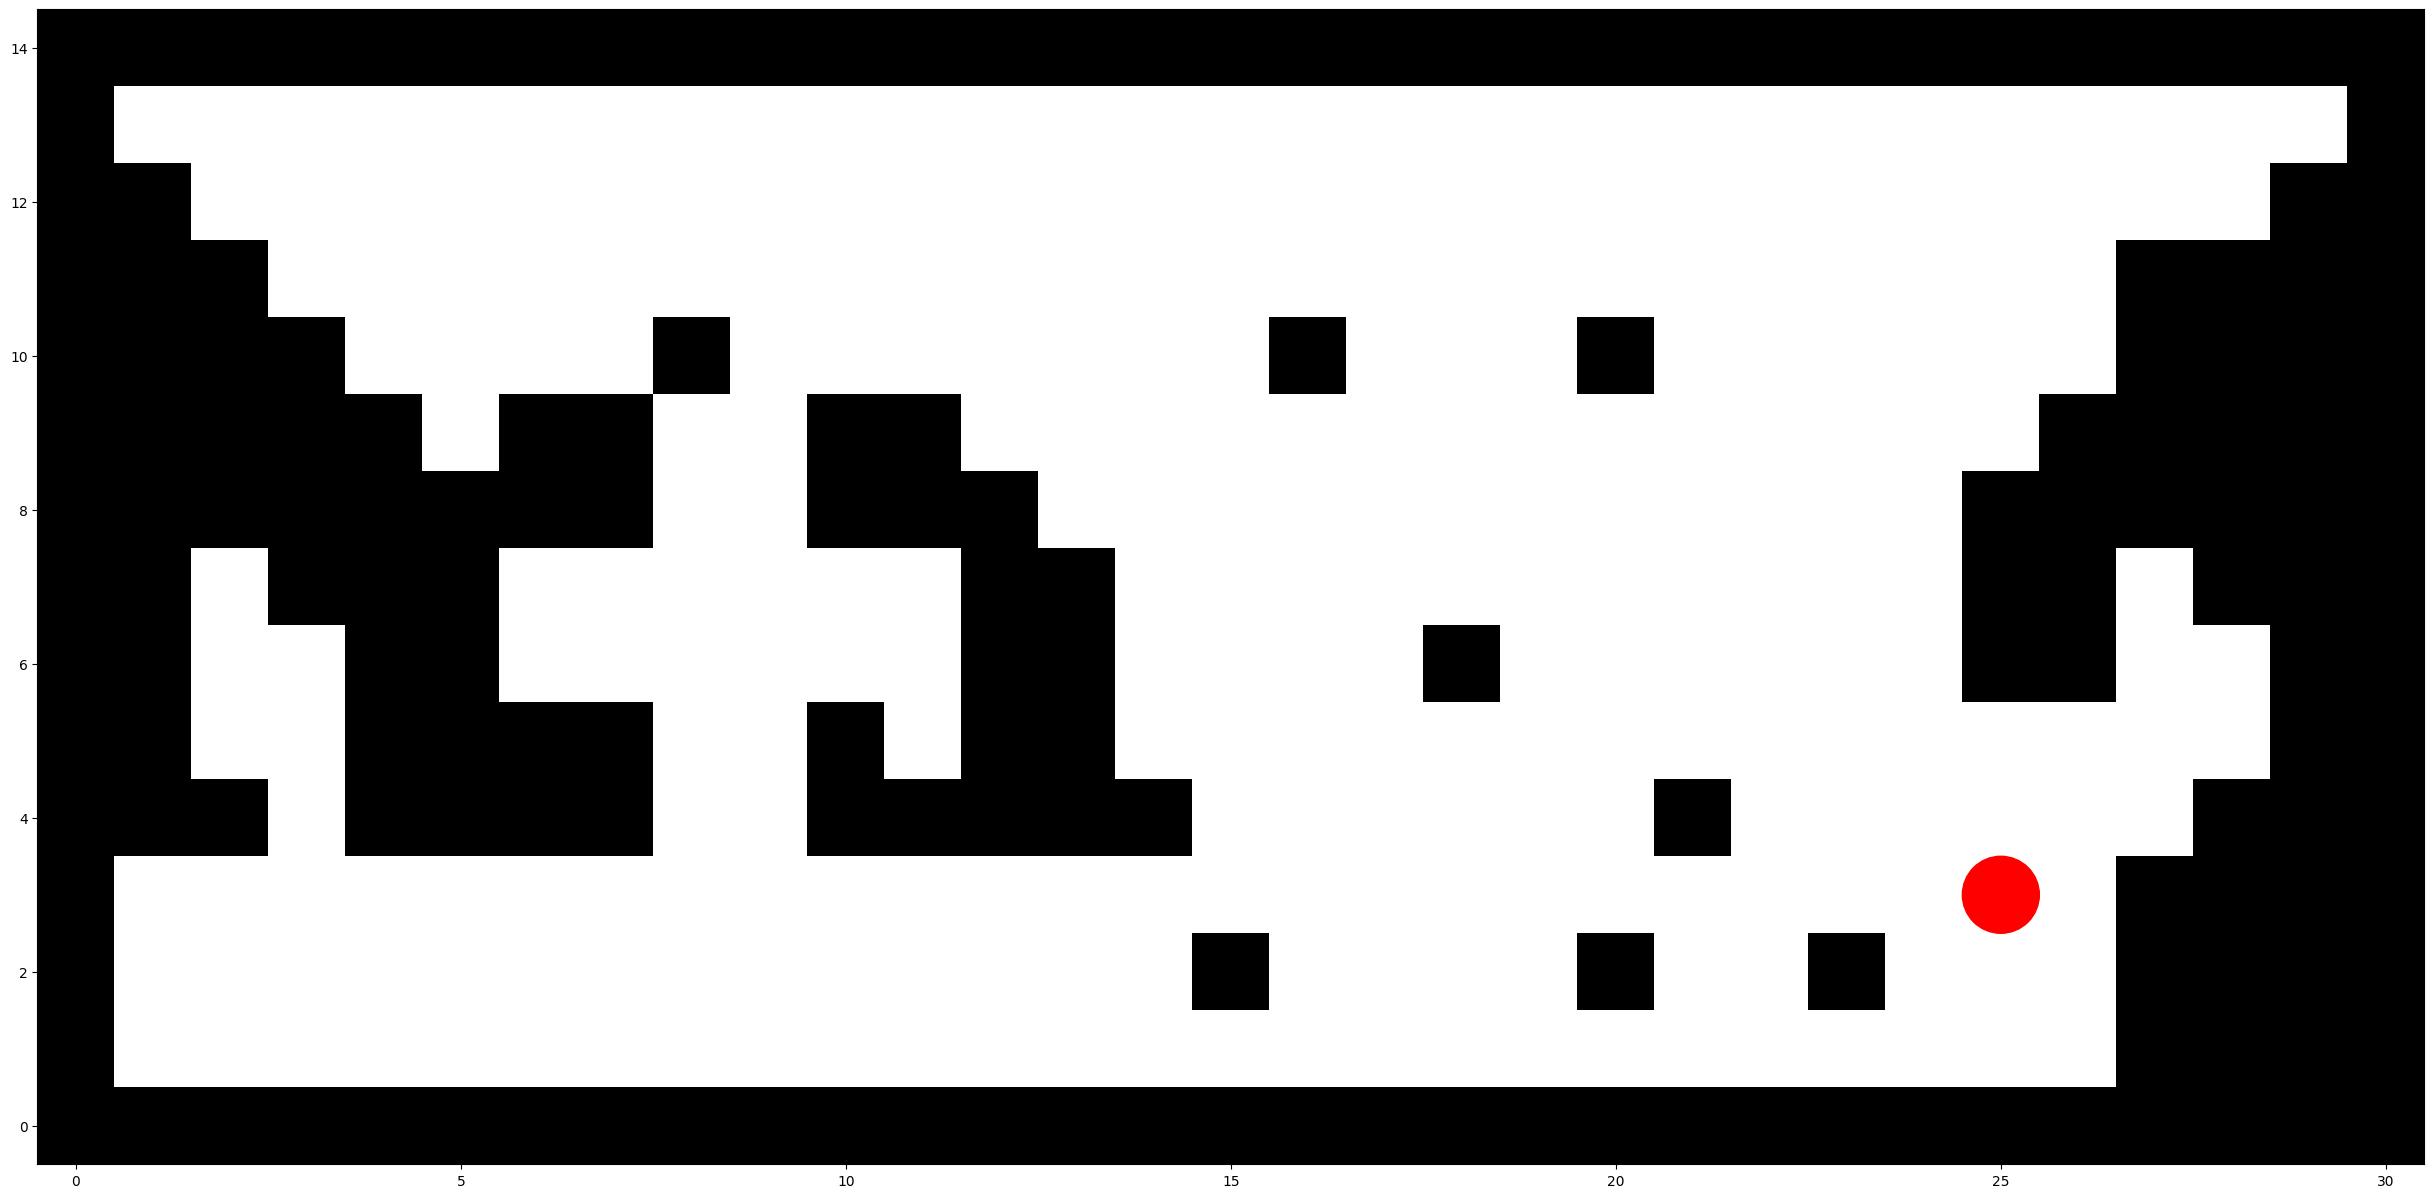

In [822]:
visualiza_mapa()

In [823]:
nav_estados = []
for i in range(0,mapa.shape[1]):
    for j in range(0,mapa.shape[0]):
        nav_estados.append(tuple([i,j]))
len(nav_estados)


465

In [824]:
nav_acciones = ['esperar','N','NE','E','SE','S','SO','O','NO']

In [825]:
def hay_colision(estado):
    # Verifica si hay una colisión en la casilla especificada por estado
    return mapa[estado[1], estado[0]] == 1

def es_terminal(estado):
    return estado == destino

def aplica_accion(estado, accion):
    # Si hay colisión en el estado actual, el estado no cambia pues no hay moviemientos posibles
    if hay_colision(estado):
        return estado
    x = estado[0]
    y = estado[1]

    # Actualiza las coordenadas x, y según la acción tomada
    if accion == 'N':
        y += 1
    elif accion == 'S':
        y -= 1
    elif accion == 'E':
        x += 1
    elif accion == 'O':
        x -= 1
    elif accion == 'NE':
        y += 1
        x += 1
    elif accion == 'SE':
        y -= 1
        x += 1
    elif accion == 'SO':
        y -= 1
        x -= 1
    elif accion == 'NO':
        y += 1
        x -= 1
    return x, y

def obtiene_posibles_errores(accion):
    # Devuelve una lista de posibles acciones erróneas que podrían ocurrir al ejecutar la acción dada, debido al
    # efecto estocástico de realizar las acciones.
    if accion == 'N':
        errores = ['NE', 'NO']
    elif accion == 'S':
        errores = ['SE', 'SO']
    elif accion == 'E':
        errores = ['NE', 'SE']
    elif accion == 'O':
        errores = ['NO', 'SO']
    elif accion == 'NE':
        errores = ['N', 'E']
    elif accion == 'NO':
        errores = ['N', 'O']
    elif accion == 'SE':
        errores = ['S', 'E']
    elif accion == 'SO':
        errores = ['S', 'O']
    else:
        errores = []
    return errores
    
def estados_sin_obstaculos():
    # Devuelve una lista de estados que no tienen obstáculos
    return [estado for estado in nav_estados if not hay_colision(estado)]

def acciones_posibles(estado):
    return [accion for accion in nav_acciones if not hay_colision(estado)]

def escoger_accion(estado):
    # Si el estado no está en la tabla Q, inicializa sus valores a ceros
    if estado not in Q_table:
        Q_table[estado] = np.zeros(len(nav_acciones))
        
    return np.random.randint(0, len(nav_acciones)) 

def obtener_politica(politica,Q_table):
    # Genera una política basada en la tabla Q
    politica = {}
    for estado in nav_estados:
        if estado in Q_table:
            politica[estado] = np.argmax(Q_table[estado])
        else:
            politica[estado] = 0
    return politica

penalizacion_colision = 10000
recompensa_objetivo_alcanzado = 1000
penalizacion_esperar = 200
penalizacion_casilla_adyacente_obstaculo = 500

def obtiene_recompensa(estado, accion):
    x, y = estado
    if estado == destino:
        return recompensa_objetivo_alcanzado
    elif hay_colision(estado):
        return -penalizacion_colision
    elif accion == 'esperar':
        return -penalizacion_esperar      

    for accion_error in obtiene_posibles_errores(accion):
        estado_vecino = aplica_accion(estado, accion_error)
        if hay_colision(estado_vecino):
            return -penalizacion_casilla_adyacente_obstaculo

    # Normaliza la recompensa en función de la distancia euclidiana al destino
    distancia = np.sqrt((x - destino[0])**2 + (y - destino[1])**2)
    return - distancia / np.sqrt(destino[0]**2 + destino[1]**2)


    # Calcula la recompensa en función de la distancia euclidiana al destino
    return - np.sqrt((x - destino[0])**2 + (y - destino[1])**2)

def visualiza_politica(politica):
    # Visualiza el mapa y la política actual mediante flechas
    visualiza_mapa()
    for estado in nav_estados:
        accion = politica.get(estado, 'esperar') # Si el estado no está en el diccionario, se devuelve esperar por defecto
        if accion == 'esperar':
            continue
        e1 = aplica_accion(estado, accion)
        x0 = estado[0]
        y0 = estado[1]
        x1 = e1[0]
        y1 = e1[1]
        
        plt.gca().arrow(x0, y0, (x1 - x0) * 0.6, (y1 - y0) * 0.6,
                        head_width=0.3, head_length=0.3, fc='black', ec='black')
        
def genera_secuencia(estado,accion,politica,pasos):
    st,at = estado,accion
    rt = obtiene_recompensa(st,at)
    secuencia = [(st,at,rt)]
    paso = 0
    while not es_terminal(st) and paso < pasos:
        next_state = aplica_accion(st,at)
        st = next_state
        at = politica[st]
        rt = obtiene_recompensa(st,at)
        secuencia.append((st,at,rt))
        paso+=1
    return secuencia


def first_visit(t, sequence):
    st, at, _ = sequence[t]
    for i, (si, ai, _) in enumerate(sequence[:t]):
        if si == st and ai == at:
            return False
    return True

        
        
    

In [826]:

racum = defaultdict(list)
policy = {s: random.choice(nav_acciones) for s in nav_estados}
Q_table = {}

gamma = 0.5
epocas = 5000
max_pasos = 500

for epoca in range(epocas):
    estado = random.choice(estados_sin_obstaculos())
    accion_index = escoger_accion(estado)
    accion = nav_acciones[accion_index]
    episodio = genera_secuencia(estado,accion,policy,max_pasos)
    
    for t,(st,at,rt) in enumerate(episodio):
        nuevo_estado = aplica_accion(st,at)
        if st not in Q_table:
            Q_table[st] = np.zeros(len(nav_acciones))
            
        if first_visit(t,episodio):
            U = sum(gamma**(i-t)*rt for i in range(t,len(episodio)))
            index = nav_acciones.index(at)
            racum[(st,at)].append(U)
            Q_table[st][index] = np.mean(racum[(st,at)])
            policy[st] = nav_acciones[np.argmax(Q_table[st])]
        
print(policy)            

        

{(0, 0): 'N', (0, 1): 'NE', (0, 2): 'O', (0, 3): 'O', (0, 4): 'esperar', (0, 5): 'S', (0, 6): 'SE', (0, 7): 'NE', (0, 8): 'S', (0, 9): 'E', (0, 10): 'SE', (0, 11): 'O', (0, 12): 'SE', (0, 13): 'esperar', (0, 14): 'NE', (1, 0): 'NE', (1, 1): 'NE', (1, 2): 'NE', (1, 3): 'SE', (1, 4): 'esperar', (1, 5): 'O', (1, 6): 'NO', (1, 7): 'NE', (1, 8): 'SE', (1, 9): 'E', (1, 10): 'NE', (1, 11): 'E', (1, 12): 'NO', (1, 13): 'esperar', (1, 14): 'SE', (2, 0): 'NO', (2, 1): 'NO', (2, 2): 'N', (2, 3): 'S', (2, 4): 'esperar', (2, 5): 'E', (2, 6): 'NE', (2, 7): 'esperar', (2, 8): 'E', (2, 9): 'NO', (2, 10): 'N', (2, 11): 'NO', (2, 12): 'E', (2, 13): 'SE', (2, 14): 'O', (3, 0): 'esperar', (3, 1): 'NO', (3, 2): 'SO', (3, 3): 'NE', (3, 4): 'S', (3, 5): 'SO', (3, 6): 'O', (3, 7): 'esperar', (3, 8): 'E', (3, 9): 'N', (3, 10): 'SO', (3, 11): 'E', (3, 12): 'NE', (3, 13): 'SE', (3, 14): 'esperar', (4, 0): 'esperar', (4, 1): 'NO', (4, 2): 'SO', (4, 3): 'S', (4, 4): 'esperar', (4, 5): 'NO', (4, 6): 'NE', (4, 7): '

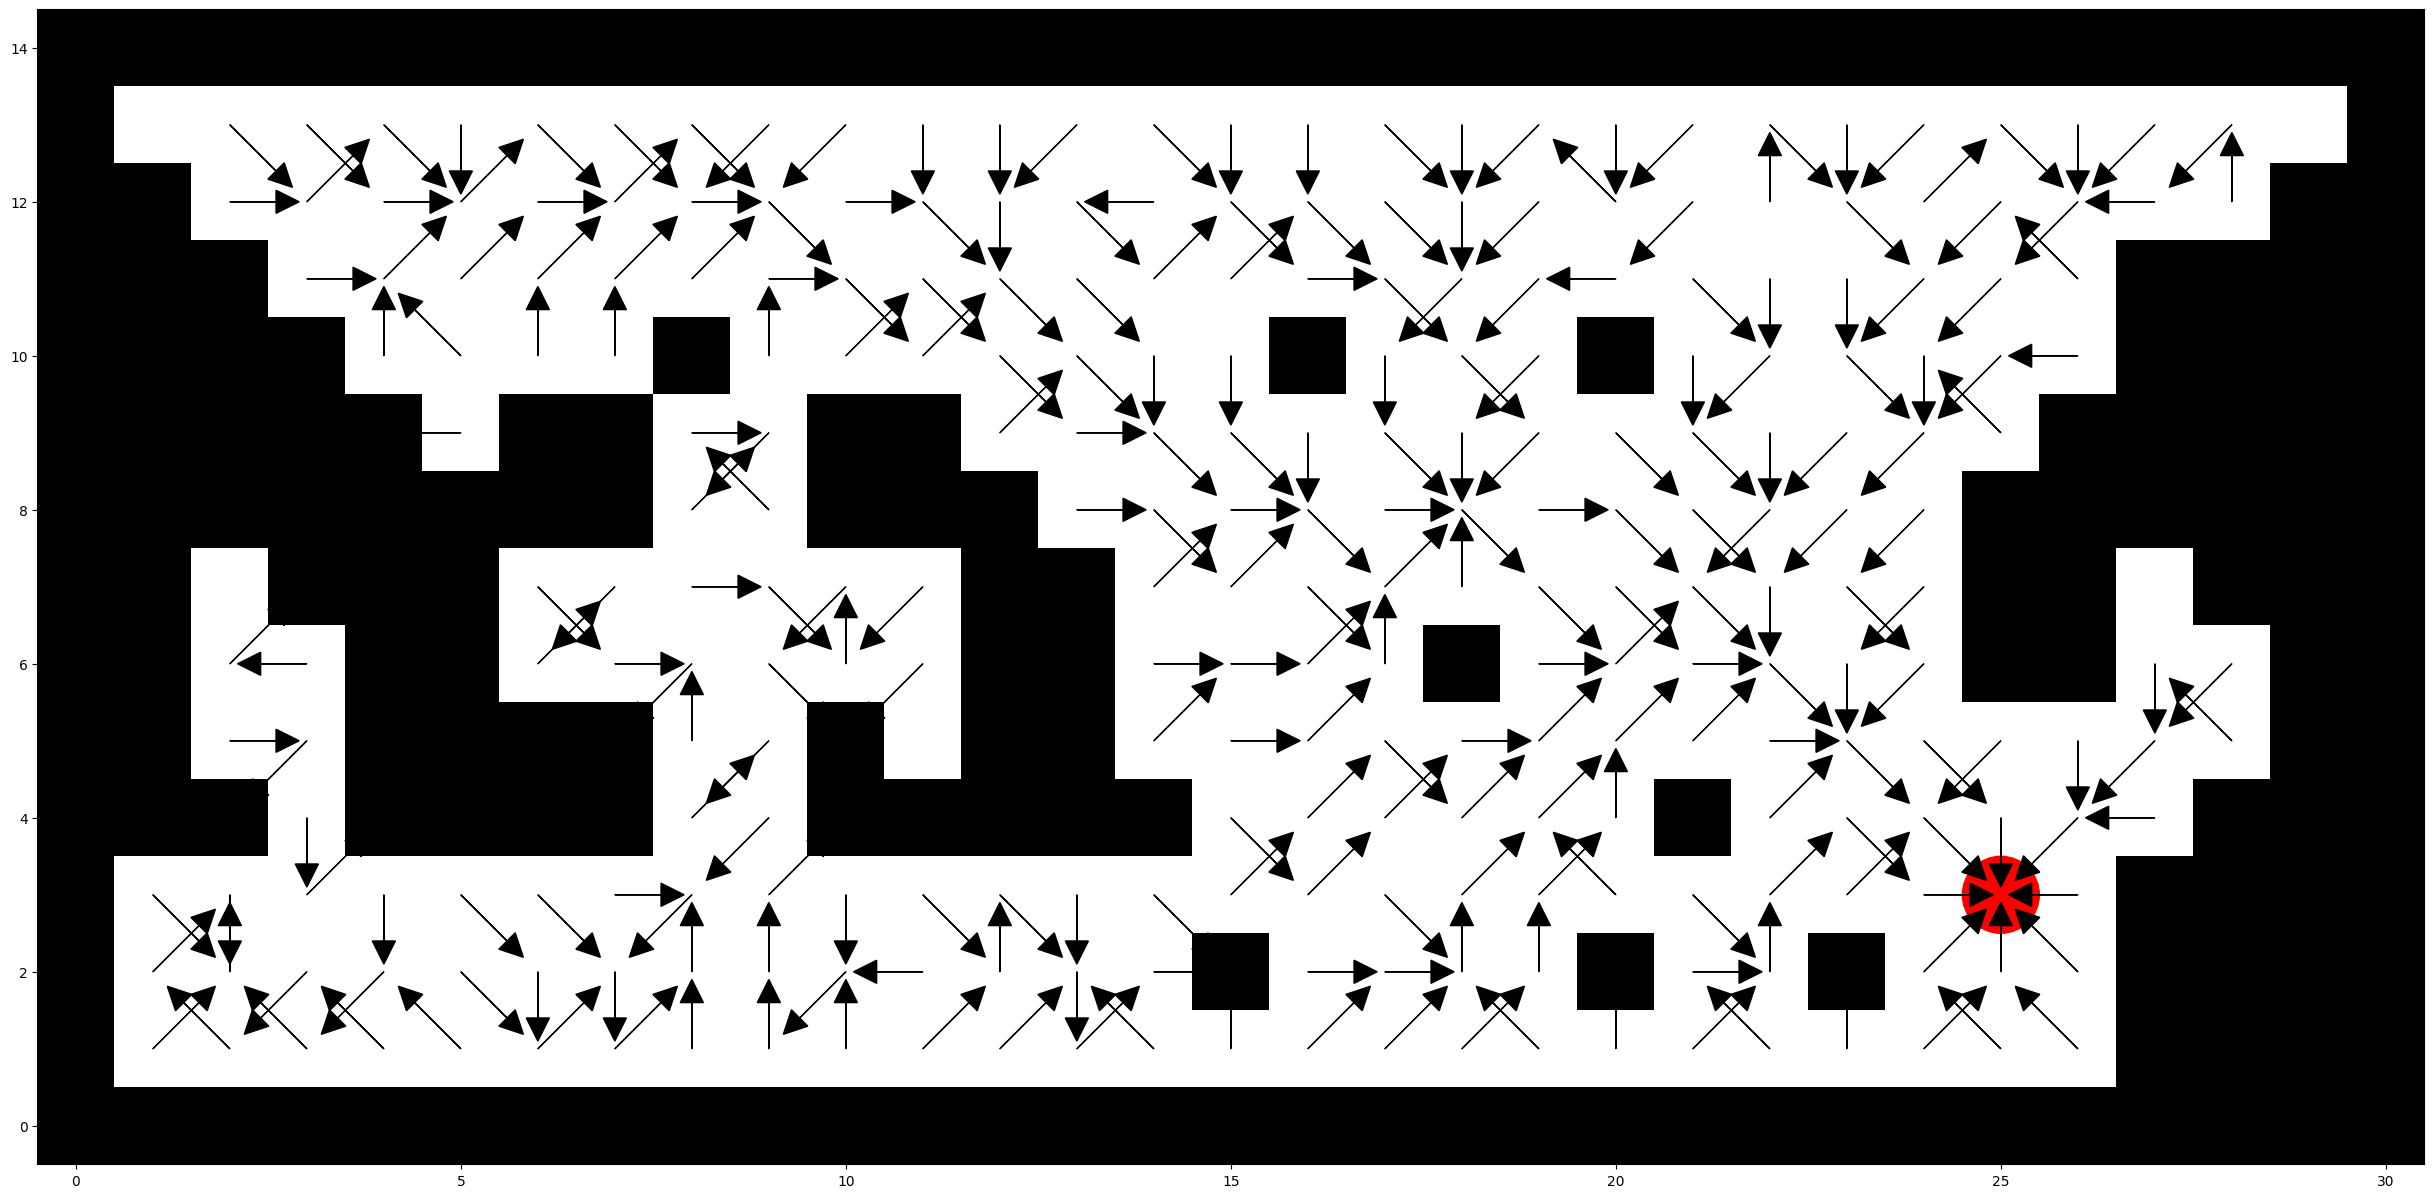

In [827]:
visualiza_politica(policy)